# Modelling Expert's Choices for Importance Assignment

In this workbook we do the main work on modelling the choices made from the Narrative Importance web experiment using mixture models. We show how we can easily estimate such models using [pyro.ai](http://pyro.ai). The main process is:

1. Load the data from the online experiment
2. Compute features for each track
   - True peak to integrated loudness
   - Ratio of speech in track (see MusicSpeechSFx.ipynb discriminator)
   - Ratio of music in track
   - Total Duration
3. Code and fit the mixture model in pyro
4. Test against a set of data
5. Test against the producer experiment

Initially we load the necessary models as well as the data from the online experiment:

In [32]:
from __future__ import print_function

# Import relevant modules and load data.
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np 
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
torch.manual_seed(3)
from torch.distributions import constraints
from matplotlib import pyplot

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
import matplotlib.pyplot as pyplot

import tqdm


smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3')
pyro.enable_validation(True)
np.random.seed(1)


df = pd.read_csv('../assets/json/features_classes_importances.csv')
df.head()

,Unnamed: 0,session_id,object_id,object_name,asset_fname,assigned,low,medium,high,essential,...,sc_max,sc_mean,sc_min,total_duration,tpti,true_peak,class,p_music,p_sfx,p_speech
0,0,5dp799,0,Bird Taking Flight,BirdTakingFlight.wav,1,0,1,0,0,...,0.478183,0.295117,0.183324,6.246168,0.317585,-12.1,sfx,0.0,1.0,0.0
1,1,8DL552,0,Bird Taking Flight,BirdTakingFlight.wav,2,0,0,1,0,...,0.478183,0.295117,0.183324,6.246168,0.317585,-12.1,sfx,0.0,1.0,0.0
2,2,8SN247,0,Bird Taking Flight,BirdTakingFlight.wav,1,0,1,0,0,...,0.478183,0.295117,0.183324,6.246168,0.317585,-12.1,sfx,0.0,1.0,0.0
3,3,0BA352,0,Bird Taking Flight,BirdTakingFlight.wav,2,0,0,1,0,...,0.478183,0.295117,0.183324,6.246168,0.317585,-12.1,sfx,0.0,1.0,0.0
4,4,7SD746,0,Bird Taking Flight,BirdTakingFlight.wav,0,1,0,0,0,...,0.478183,0.295117,0.183324,6.246168,0.317585,-12.1,sfx,0.0,1.0,0.0


Below are the name of the tracks (objects) and the filenames they correspond to.

In [22]:
df[['object_name', 'asset_fname']].drop_duplicates()

,object_name,asset_fname
0,Bird Taking Flight,BirdTakingFlight.wav
34,Boy Humming,BoyHumming.wav
68,Boy Panting + Birds,BoyPanting+Birds.wav
102,Boy Panting,BoyPanting.wav
136,Boy Running,BoyRunning.wav
170,Boy Running + Falling,BoyRunningFalling.wav
204,Boy Voice 1,BoyVoice1.wav
238,Boy Voice 2,BoyVoice2.wav
272,Branch Break,BranchBreak.wav
306,Creature Footsteps,CreatureFootsteps.wav


Split the dataset into training and testing with a predefined random seed

In [23]:
object_labels = ['asset_fname']
feature_labels = ['assigned','tpti','p_speech','p_music', 'p_sfx', 'total_duration']
train_df, test_df = train_test_split(df[object_labels+feature_labels], test_size=0.1, shuffle=True, random_state=1)

Split into objects and their data

In [24]:
objects = train_df[object_labels].values
data = train_df[feature_labels].values.T
objects_test = test_df[object_labels].values
data_test = test_df[feature_labels].values.T

Fetch specific features

In [25]:
object_name = df['asset_fname'].values
rms = df['tpti'].values
pspeech = df['p_speech'].values
pmusic = df['p_music'].values
psfx = df['p_sfx'].values

dur = df['total_duration'].values
importances = df['assigned'].values

Statistics about features

Text(0, 0.5, 'p')

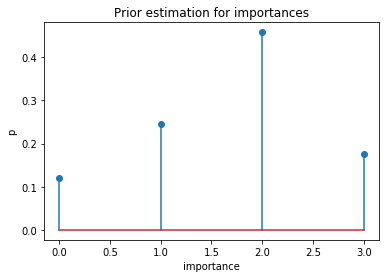

In [27]:
importance_counts = defaultdict(lambda: 0)

rms_loc_e = np.mean(rms[importances==3])
rms_loc_h = np.mean(rms[importances==2])
rms_loc_m = np.mean(rms[importances==1])
rms_loc_l = np.mean(rms[importances==0])

rms_scale_e = np.std(rms[importances==3])
rms_scale_h = np.std(rms[importances==2])
rms_scale_m = np.std(rms[importances==1])
rms_scale_l = np.std(rms[importances==0])

pspeech_loc_e = np.mean(pspeech[importances==3])
pspeech_loc_h = np.mean(pspeech[importances==2])
pspeech_loc_m = np.mean(pspeech[importances==1])
pspeech_loc_l = np.mean(pspeech[importances==0])

pspeech_scale_e = np.std(pspeech[importances==3])
pspeech_scale_h = np.std(pspeech[importances==2])
pspeech_scale_m = np.std(pspeech[importances==1])
pspeech_scale_l = np.std(pspeech[importances==0])

dur_loc_e = np.mean(dur[importances==3])
dur_loc_h = np.mean(dur[importances==2])
dur_loc_m = np.mean(dur[importances==1])
dur_loc_l = np.mean(dur[importances==0])

dur_scale_e = np.std(dur[importances==3])
dur_scale_h = np.std(dur[importances==2])
dur_scale_m = np.std(dur[importances==1])
dur_scale_l = np.std(dur[importances==0])

sum_ = 0
for I in range(len(importances)):
    importance_counts[importances[I]] += 1
    sum_ += 1
    
importance_prior_est = np.zeros((len(importance_counts),))
for key in importance_counts.keys():
    importance_prior_est[key] = importance_counts[key]/sum_
    
plt.stem([0,1,2,3], importance_prior_est)
plt.title('Prior estimation for importances')
plt.xlabel('importance')
plt.ylabel('p')    

Prepare data for using with pyro 

In [33]:
data[2,:] = data[2,:]*0.8 + 0.1 + np.random.randn(*data[2,:].shape)*0.001
data_test[2,:] = data_test[2,:]*0.8 + 0.1 + np.random.randn(*data_test[2,:].shape)*0.001
data[3,:] = data[3,:]*0.8 + 0.1 + np.random.randn(*data[3,:].shape)*0.001
data_test[3,:] = data_test[3,:]*0.8 + 0.1 + np.random.randn(*data_test[3,:].shape)*0.001
data[4,:] = data[3,:]*0.8 + 0.1 + np.random.randn(*data[3,:].shape)*0.001
data_test[4,:] = data_test[3,:]*0.8 + 0.1 + np.random.randn(*data_test[3,:].shape)*0.001
data = torch.tensor(data).float()
data_test = torch.tensor(data_test).float()

Code the mixture model (see the paper). Note that `model_b` is similar to `model` with the exception that the `assigned` is not observed (so we can use it to compute them when classifying).

In [35]:
prior_importances_est = torch.tensor(importance_prior_est)

@config_enumerate
def model(data):
    
    importances = pyro.sample("importances", pyro.distributions.Dirichlet(2*torch.ones(4)))
    with pyro.plate('components', 4) as ind:
    
        rms_alphas = pyro.sample('rms_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
        rms_betas = pyro.sample('rms_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
        
        pspeech_alphas = pyro.sample('pspeech_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4))) 
        pspeech_betas = pyro.sample('pspeech_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
        
        pmusic_alphas = pyro.sample('pmusic_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4))) 
        pmusic_betas = pyro.sample('pmusic_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))

        dur_alphas = pyro.sample('dur_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4))) 
        dur_betas = pyro.sample('dur_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
                
    with pyro.plate('observations', data.size()[1]) as ind:
      
         assigned = pyro.sample("assigned", pyro.distributions.Categorical(importances), obs=data[0,ind], infer={"enumerate": "parallel"}).long()
         rms = pyro.sample("rms", pyro.distributions.Beta(rms_alphas[assigned], rms_betas[assigned]), obs=data[1,ind], infer={"enumerate": "parallel"})
         pspeech = pyro.sample("pspeech", pyro.distributions.Beta(pspeech_alphas[assigned],pspeech_betas[assigned]), 
                               obs=data[2,ind], infer={"enumerate": "parallel"})
         pmusic = pyro.sample("pmusic", pyro.distributions.Beta(pmusic_alphas[assigned],pmusic_betas[assigned]), 
                               obs=data[4,ind], infer={"enumerate": "parallel"})
         dur = pyro.sample("dur", pyro.distributions.Gamma(concentration=dur_alphas[assigned], rate=dur_betas[assigned]), obs=data[5,ind], infer={"enumerate": "parallel"})
        
    return assigned, rms

def model_b(data):
    
    importances = pyro.sample("importances", pyro.distributions.Dirichlet(2*torch.ones(4)))
    with pyro.plate('components', 4) as ind:
    
        rms_alphas = pyro.sample('rms_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
        rms_betas = pyro.sample('rms_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
        
        pspeech_alphas = pyro.sample('pspeech_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4))) 
        pspeech_betas = pyro.sample('pspeech_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
        
        pmusic_alphas = pyro.sample('pmusic_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4))) 
        pmusic_betas = pyro.sample('pmusic_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))

        dur_alphas = pyro.sample('dur_alphas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4))) 
        dur_betas = pyro.sample('dur_betas', pyro.distributions.Gamma(concentration=7.5*torch.ones(4), rate=torch.ones(4)))
                
    with pyro.plate('observations', data.size()[1]) as ind:
      
         assigned = pyro.sample("assigned", pyro.distributions.Categorical(importances), infer={"enumerate": "parallel"}).long()
         rms = pyro.sample("rms", pyro.distributions.Beta(rms_alphas[assigned], rms_betas[assigned]), obs=data[1,ind], infer={"enumerate": "parallel"})
         pspeech = pyro.sample("pspeech", pyro.distributions.Beta(pspeech_alphas[assigned],pspeech_betas[assigned]), 
                               obs=data[2,ind], infer={"enumerate": "parallel"})
         pmusic = pyro.sample("pmusic", pyro.distributions.Beta(pmusic_alphas[assigned],pmusic_betas[assigned]), 
                               obs=data[4,ind], infer={"enumerate": "parallel"})
         dur = pyro.sample("dur", pyro.distributions.Gamma(concentration=dur_alphas[assigned], rate=dur_betas[assigned]), obs=data[5,ind], infer={"enumerate": "parallel"})
        
    
    return assigned, rms 

# Automatically specify a guide
global_guide = AutoDelta(poutine.block(model, expose=['rms_alphas', 'rms_betas', 'importances','pspeech_alphas','pspeech_betas','pmusic_alphas','pmusic_betas', 'dur_alphas', 'dur_betas']))        
    

Specify optimizer and loss

In [36]:
optim = pyro.optim.RMSprop({'lr': 0.01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

Do the fitting

In [37]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()

    # Initialize weights to uniform.
    pyro.param('auto_rms_alphas', torch.ones(4)*1, constraint=constraints.positive)
    pyro.param('auto_rms_betas', torch.ones(4)*1, constraint=constraints.positive)
    pyro.param('auto_dur_alphas', torch.ones(4)*1, constraint=constraints.positive)
    pyro.param('auto_dur_betas', torch.ones(4)*1, constraint=constraints.positive)    
    pyro.param('auto_pspeech_alphas', torch.ones(4)*1, constraint=constraints.positive)
    pyro.param('auto_pspeech_betas', torch.ones(4)*1, constraint=constraints.positive)
    pyro.param('auto_pmusic_alphas', torch.ones(4)*1, constraint=constraints.positive)
    pyro.param('auto_pmusic_betas', torch.ones(4)*1, constraint=constraints.positive)      
    pyro.param('auto_importances', torch.ones(4)*0.25, constraint=constraints.simplex)    
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 0, initial_loss = 19477.47265625


In [38]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
pbar = tqdm.tqdm_notebook(range(1500))
for i in pbar:
    loss = svi.step(data)
    losses.append(loss)
    pbar.set_postfix({'loss': loss})


Plot curves for loss and gradient norms

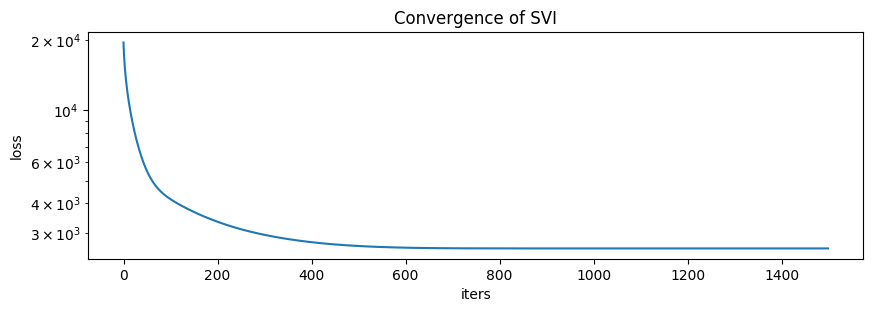

In [40]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

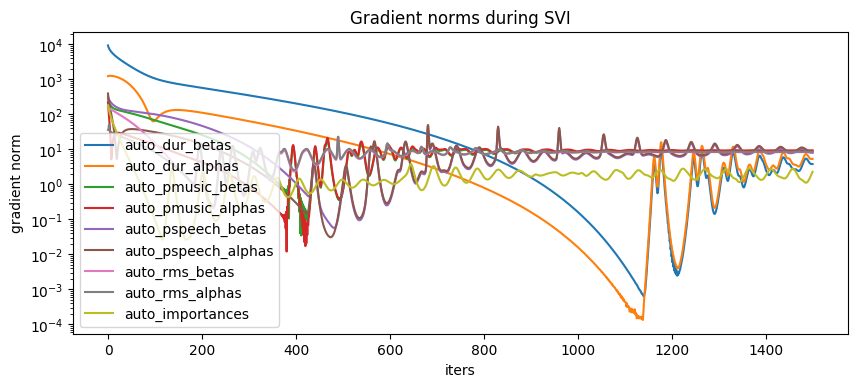

In [41]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

Show final parameters for the mixtures

In [42]:
map_estimates = global_guide(data)
rms_alphas = map_estimates['rms_alphas']
rms_betas = map_estimates['rms_betas']
dur_alphas = map_estimates['dur_alphas']
dur_betas = map_estimates['dur_betas']
pspeech_alphas = map_estimates['pspeech_alphas']
pspeech_betas = map_estimates['pspeech_betas']
importances = map_estimates['importances']
print('rms_alphas = {}'.format(rms_alphas.data.numpy()))
print('rms_betas = {}'.format(rms_betas.data.numpy()))
print('dur_alphas = {}'.format(rms_alphas.data.numpy()))
print('dur_betas = {}'.format(rms_betas.data.numpy()))
print('pspeech_alphas = {}'.format(pspeech_alphas.data.numpy()))
print('pspeech_betas = {}'.format(pspeech_betas.data.numpy()))
print('importances = {}'.format(importances.data.numpy()))

rms_alphas = [7.0093613 3.45948   2.9146962 2.1777165]
rms_betas = [6.9193454 4.4736333 4.1855235 3.2088103]
dur_alphas = [7.0093613 3.45948   2.9146962 2.1777165]
dur_betas = [6.9193454 4.4736333 4.1855235 3.2088103]
pspeech_alphas = [4.5982265 3.3788798 2.1556673 0.9241546]
pspeech_betas = [34.09347   21.575043  10.874579   1.6789632]
importances = [0.12029129 0.24585994 0.4610413  0.17280743]


Create a classifier out of the model and generate some predictions given the data in the test.

In [43]:
guide_trace = poutine.trace(global_guide).get_trace(data)  # record the globals
trained_model = poutine.replay(model_b, trace=guide_trace)  # replay the globals
def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assigned"]["value"]
def get_prob(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["importances"]["value"]

y_pred = classifier(data_test)

Show the object files and predictions of their narrative importance. Note that there is a lot of disagreement so just measuring accuracy won't cut it.

In [46]:
# Add automatic assignments 
auto_assignments = []
assigned_assets = []
for I in range(len(y_pred)):
    if objects_test[I][0] not in assigned_assets:
        print('{} -> {} ({})'.format(objects_test[I], y_pred[I], data_test[0,I]))

        auto_assignments.append({'session_id': "auto", 
                                 'asset_fname': objects_test[I][0],
                                 'assigned': y_pred[I].item(),})
        assigned_assets.append(objects_test[I][0])

['Narrator.wav'] -> 3 (2.0)
['BoyVoice2.wav'] -> 3 (3.0)
['BoyPanting.wav'] -> 2 (2.0)
['BranchBreak.wav'] -> 0 (1.0)
['CreatureFootsteps.wav'] -> 3 (1.0)
['GirlVoice.wav'] -> 2 (3.0)
['KidsVoices.wav'] -> 2 (1.0)
['BoyRunningFalling.wav'] -> 2 (2.0)
['BoyVoice1.wav'] -> 2 (2.0)
['Winds&Birds.wav'] -> 0 (2.0)
['SpookyStrings.wav'] -> 1 (1.0)
['Crickets.wav'] -> 0 (0.0)
['BirdTakingFlight.wav'] -> 2 (2.0)
['TreeFalling.wav'] -> 0 (2.0)
['Flute.wav'] -> 0 (0.0)
['Frogs.wav'] -> 0 (0.0)
['CreatureVoice.wav'] -> 1 (1.0)
['BoyHumming.wav'] -> 2 (2.0)
['BoyPanting+Birds.wav'] -> 2 (2.0)
['BoyRunning.wav'] -> 2 (2.0)
['Growl.wav'] -> 0 (1.0)
['CreatureSmile.wav'] -> 2 (3.0)


In [47]:
# Add the assignments by the producer experiment (ground truth)

orig_assignments = [
 {'session_id': "original",
  'asset_fname': "Narrator.wav",
  'assigned': 3
 },
 {'session_id': "original",
  'asset_fname': "CreatureLanding.wav",
  'assigned': 2
 },
 {'session_id': "original",
  'asset_fname': "Growl.wav",
  'assigned': 1
 },    
 {'session_id': "original",
  'asset_fname': "BoyPanting+Birds.wav",
  'assigned': 3
 },        
 {'session_id': "original",
  'asset_fname': "BranchBreak.wav",
  'assigned': 0
 },   
 {'session_id': "original",
  'asset_fname': "KidsVoices.wav",
  'assigned': 3
 },        
 {'session_id': "original",
  'asset_fname': "BoyPanting.wav",
  'assigned': 2
 },   
 {'session_id': "original",
  'asset_fname': "GirlVoice.wav",
  'assigned': 1
 },  
 {'session_id': "original",
  'asset_fname': "CreatureVoice.wav",
  'assigned': 1
 },      
 {'session_id': "original",
  'asset_fname': "SpookyStrings.wav",
  'assigned': 1
 },     
 {'session_id': "original",
  'asset_fname': "Frogs.wav",
  'assigned': 0
 },   
 {'session_id': "original",
  'asset_fname': "BoyHumming.wav",
  'assigned': 2
 },    
 {'session_id': "original",
  'asset_fname': "BoyRunning.wav",
  'assigned': 3
 },  
 {'session_id': "original",
  'asset_fname': "TreeFalling.wav",
  'assigned': 0
 },        
 {'session_id': "original",
  'asset_fname': "BirdTakingFlight.wav",
  'assigned': 0
 },           
 {'session_id': "original",
  'asset_fname': "Flute.wav",
  'assigned': 1
 }, 
 {'session_id': "original",
  'asset_fname': "BoyVoice1.wav",
  'assigned': 3
 }, 
 {'session_id': "original",
  'asset_fname': "BoyRunningFalling.wav",
  'assigned': 3
 },
 {'session_id': "original",
  'asset_fname': "CreatureSmile.wav",
  'assigned': 1
 },   
 {'session_id': "original",
  'asset_fname': "BoyVoice2.wav",
  'assigned': 3
 },   
 {'session_id': "original",
  'asset_fname': "Crickets.wav",
  'assigned': 0
 },     
 {'session_id': "original",
  'asset_fname': "Winds&Birds.wav",
  'assigned': 0
 },   
 {'session_id': "original",
  'asset_fname': "CreatureLanding.wav",
  'assigned': 2
 },        
]


Add and store the automatic importance assignments to a new .csv file

In [48]:
auto_df = pd.DataFrame.from_records(auto_assignments)
original_df = pd.DataFrame.from_records(orig_assignments)
adf = df.append(original_df).append(auto_df)
adf.to_csv('../assets/json/features_classes_importances_auto.csv')

/home/emmanouc/.local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Extract parameters as numpy arrays 

In [50]:
inferred_model = infer_discrete(trained_model, temperature=0,
                                first_available_dim=-2) 
trace = poutine.trace(inferred_model).get_trace(data)
rms_alphas = trace.nodes["rms_alphas"]["value"].detach().numpy()
rms_betas = trace.nodes["rms_betas"]["value"].detach().numpy()
dur_alphas = trace.nodes["dur_alphas"]["value"].detach().numpy()
dur_betas = trace.nodes["dur_betas"]["value"].detach().numpy()
pspeech_alphas = trace.nodes["pspeech_alphas"]["value"].detach().numpy()
pspeech_betas = trace.nodes["pspeech_betas"]["value"].detach().numpy()
pmusic_alphas = trace.nodes["pmusic_alphas"]["value"].detach().numpy()
pmusic_betas = trace.nodes["pmusic_betas"]["value"].detach().numpy()

Compute confidence interavals

In [51]:
N=10000

cardinal_intervals = {}


traces = {
    'tpti' : { 'low': np.random.beta(a=rms_alphas[0], b=rms_betas[0], size=(N,)),
               'medium': np.random.beta(a=rms_alphas[1], b=rms_betas[1], size=(N,)),
               'high': np.random.beta(a=rms_alphas[2], b=rms_betas[2], size=(N,)),
               'essential': np.random.beta(a=rms_alphas[2], b=rms_betas[2], size=(N,)),
             },
    'pspeech': {
        'low': np.random.beta(a=pspeech_alphas[0], b=pspeech_betas[0], size=(N)),
        'medium': np.random.beta(a=pspeech_alphas[1], b=pspeech_betas[1], size=(N)),
        'high': np.random.beta(a=pspeech_alphas[2], b=pspeech_betas[2], size=(N)),
        'essential': np.random.beta(a=pspeech_alphas[3], b=pspeech_betas[3], size=(N)),       
    },
    'duration': {
        'low': np.random.gamma(shape=dur_alphas[0], scale=1/dur_betas[0], size=(N,)),
        'medium':np.random.gamma(shape=dur_alphas[1], scale=1/dur_betas[1], size=(N,)),
        'high': np.random.gamma(shape=dur_alphas[2], scale=1/dur_betas[2], size=(N,)),
        'essential': np.random.gamma(shape=dur_alphas[3], scale=1/dur_betas[3], size=(N,)),       
    },       
    'pmusic': {
        'low':np.random.beta(a=pmusic_alphas[0], b=pmusic_betas[0], size=(N)),
        'medium': np.random.beta(a=pmusic_alphas[1], b=pmusic_betas[1], size=(N)),
        'high': np.random.beta(a=pmusic_alphas[2], b=pmusic_betas[2], size=(N)),
        'essential': np.random.beta(a=pmusic_alphas[3], b=pmusic_betas[3], size=(N)),       
    },

    
}

for trace in traces:
    cardinal_intervals[trace] = {}
    for imp in ['low', 'medium', 'high', 'essential']:
        cardinal_intervals[trace][imp] = (np.percentile(traces[trace][imp], 2.5), np.percentile(traces[trace][imp], 97.5))
        print("P({0:0.2f} < {1}_{2} < {3:0.2f}) = 0.95".format(np.percentile(traces[trace][imp], 2.5), trace, imp, np.percentile(traces[trace][imp], 97.5)))

P(0.26 < tpti_low < 0.75) = 0.95
P(0.14 < tpti_medium < 0.77) = 0.95
P(0.11 < tpti_high < 0.76) = 0.95
P(0.11 < tpti_essential < 0.76) = 0.95
P(0.04 < pspeech_low < 0.24) = 0.95
P(0.03 < pspeech_medium < 0.30) = 0.95
P(0.02 < pspeech_high < 0.39) = 0.95
P(0.01 < pspeech_essential < 0.89) = 0.95
P(0.94 < duration_low < 147.26) = 0.95
P(0.52 < duration_medium < 114.55) = 0.95
P(0.50 < duration_high < 76.83) = 0.95
P(0.70 < duration_essential < 71.71) = 0.95
P(0.09 < pmusic_low < 0.34) = 0.95
P(0.04 < pmusic_medium < 0.60) = 0.95
P(0.04 < pmusic_high < 0.60) = 0.95
P(0.06 < pmusic_essential < 0.40) = 0.95


Format the figures nicely to be inserted into the papers
The code is adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
Width and max height in inches for IEEE journals taken from
http://computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf


In [52]:
from numpy import sqrt as sqrt
import matplotlib
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              #'text.latex.preamble': ['\usepackage{gensymb}'],
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

Calculate, plot, and save mixtures defined by `type_`

/home/emmanouc/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


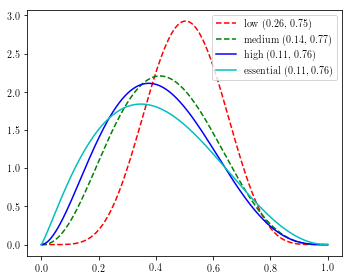

In [53]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
type_ = 'tpti'
x = np.linspace (0, 1, 200) 
y1 = scipy.stats.beta.pdf(x, a=rms_alphas[0], b=rms_betas[0]) #a is alpha, loc is beta???
y2 = scipy.stats.beta.pdf(x, a=rms_alphas[1], b=rms_betas[1]) #a is alpha, loc is beta???
y3 = scipy.stats.beta.pdf(x, a=rms_alphas[2], b=rms_betas[2]) #a is alpha, loc is beta???
y4 = scipy.stats.beta.pdf(x, a=rms_alphas[3], b=rms_betas[3]) #a is alpha, loc is beta???

plt.figure(figsize=(5,4))

plt.plot(x, y1, "y--", label=(r'$\alpha=29, \beta=3$'), color='r') 
plt.plot(x, y2, "y--", label=(r'$\alpha=29, \beta=3$'), color='g') 
plt.plot(x, y3, "y-", label=(r'$\alpha=29, \beta=3$'), color='b') 
plt.plot(x, y4, "y-", label=(r'$\alpha=29, \beta=3$'), color='c') 

plt.legend(['low ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['low'][0], cardinal_intervals[type_]['low'][1] ),
            'medium ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['medium'][0], cardinal_intervals[type_]['medium'][1] ),
            'high ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['high'][0], cardinal_intervals[type_]['high'][1] ),
            'essential ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['essential'][0], cardinal_intervals[type_]['essential'][1] ),
            ])
plt.tight_layout()

latexify()
plt.savefig('{}_estimated.pdf'.format(type_), dpi=300)

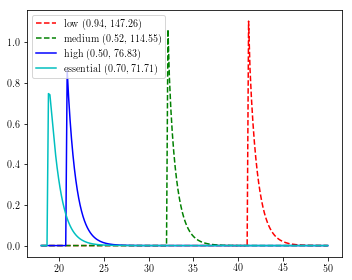

In [54]:
type_ = 'duration'

x = np.linspace (18, 50, 200) 
y1 = scipy.stats.gamma.pdf(x, a=dur_alphas[0], loc=1/dur_betas[0]) #a is alpha, loc is beta???
y2 = scipy.stats.gamma.pdf(x, a=dur_alphas[1], loc=1/dur_betas[1]) #a is alpha, loc is beta???
y3 = scipy.stats.gamma.pdf(x, a=dur_alphas[2], loc=1/dur_betas[2]) #a is alpha, loc is beta???
y4 = scipy.stats.gamma.pdf(x, a=dur_alphas[3], loc=1/dur_betas[3]) #a is alpha, loc is beta???
plt.figure(figsize=(5,4))

plt.plot(x, y1, "y--", label=(r'$\alpha=29, \beta=3$'), color='r') 
plt.plot(x, y2, "y--", label=(r'$\alpha=29, \beta=3$'), color='g') 
plt.plot(x, y3, "y-", label=(r'$\alpha=29, \beta=3$'), color='b') 
plt.plot(x, y4, "y-", label=(r'$\alpha=29, \beta=3$'), color='c') 

plt.legend(['low ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['low'][0], cardinal_intervals[type_]['low'][1] ),
            'medium ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['medium'][0], cardinal_intervals[type_]['medium'][1] ),
            'high ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['high'][0], cardinal_intervals[type_]['high'][1] ),
            'essential ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['essential'][0], cardinal_intervals[type_]['essential'][1] ),
            ])

plt.tight_layout()
latexify()

plt.savefig('{}_estimated.pdf'.format(type_), dpi=300)

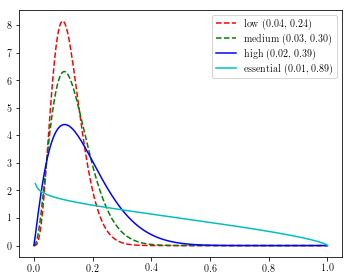

In [55]:
type_ = 'pspeech'

x = np.linspace (0, 1, 200) 
y1 = scipy.stats.beta.pdf(x, a=pspeech_alphas[0], b=pspeech_betas[0]) #a is alpha, loc is beta???
y2 = scipy.stats.beta.pdf(x, a=pspeech_alphas[1], b=pspeech_betas[1]) #a is alpha, loc is beta???
y3 = scipy.stats.beta.pdf(x, a=pspeech_alphas[2], b=pspeech_betas[2]) #a is alpha, loc is beta???
y4 = scipy.stats.beta.pdf(x, a=pspeech_alphas[3], b=pspeech_betas[3]) #a is alpha, loc is beta???
plt.figure(figsize=(5,4))

plt.plot(x, y1, "y--", label=(r'$\alpha=29, \beta=3$'), color='r') 
plt.plot(x, y2, "y--", label=(r'$\alpha=29, \beta=3$'), color='g') 
plt.plot(x, y3, "y-", label=(r'$\alpha=29, \beta=3$'), color='b') 
plt.plot(x, y4, "y-", label=(r'$\alpha=29, \beta=3$'), color='c') 

plt.legend(['low ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['low'][0], cardinal_intervals[type_]['low'][1] ),
            'medium ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['medium'][0], cardinal_intervals[type_]['medium'][1] ),
            'high ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['high'][0], cardinal_intervals[type_]['high'][1] ),
            'essential ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['essential'][0], cardinal_intervals[type_]['essential'][1] ),
            ])
plt.tight_layout()
latexify()

plt.savefig('{}_estimated.pdf'.format(type_), dpi=300)

<Figure size 648x504 with 0 Axes>

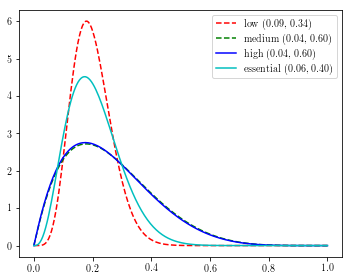

In [56]:
type_ = 'pmusic'

plt.figure(figsize=(9,7))
x = np.linspace (0, 1, 200) 
y1 = scipy.stats.beta.pdf(x, a=pmusic_alphas[0], b=pmusic_betas[0]) #a is alpha, loc is beta???
y2 = scipy.stats.beta.pdf(x, a=pmusic_alphas[1], b=pmusic_betas[1]) #a is alpha, loc is beta???
y3 = scipy.stats.beta.pdf(x, a=pmusic_alphas[2], b=pmusic_betas[2]) #a is alpha, loc is beta???
y4 = scipy.stats.beta.pdf(x, a=pmusic_alphas[3], b=pmusic_betas[3]) #a is alpha, loc is beta???

plt.figure(figsize=(5,4))

plt.plot(x, y1, "y--", label=(r'$\alpha=29, \beta=3$'), color='r') 
plt.plot(x, y2, "y--", label=(r'$\alpha=29, \beta=3$'), color='g') 
plt.plot(x, y3, "y-", label=(r'$\alpha=29, \beta=3$'), color='b') 
plt.plot(x, y4, "y-", label=(r'$\alpha=29, \beta=3$'), color='c') 

plt.legend(['low ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['low'][0], cardinal_intervals[type_]['low'][1] ),
            'medium ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['medium'][0], cardinal_intervals[type_]['medium'][1] ),
            'high ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['high'][0], cardinal_intervals[type_]['high'][1] ),
            'essential ({0:0.2f}, {1:0.2f})'.format(cardinal_intervals[type_]['essential'][0], cardinal_intervals[type_]['essential'][1] ),
            ])
plt.tight_layout()
latexify()

plt.savefig('{}_estimated.pdf'.format(type_), dpi=300)

The evaluation is done in `STOIMeasurements.ipynb`.